In [1]:
from google.colab import drive # get the access from google drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# packages
import collections
from PIL import Image
import pandas as pd
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, Input, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
import keras.backend as K
from keras.callbacks import Callback
import datetime
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import io
from skimage.transform import resize
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import imgaug.augmenters as im_aug
%matplotlib inline
print("finish loading!")


finish loading!


In [3]:
path_ver = '/content/drive/MyDrive/Colab Notebooks/'
images = np.load(path_ver + 'combined_images.npy')
labels = np.load(path_ver + 'combined_labels.npy')

In [ ]:
labels.shape

(-0.5, 255.5, 255.5, -0.5)

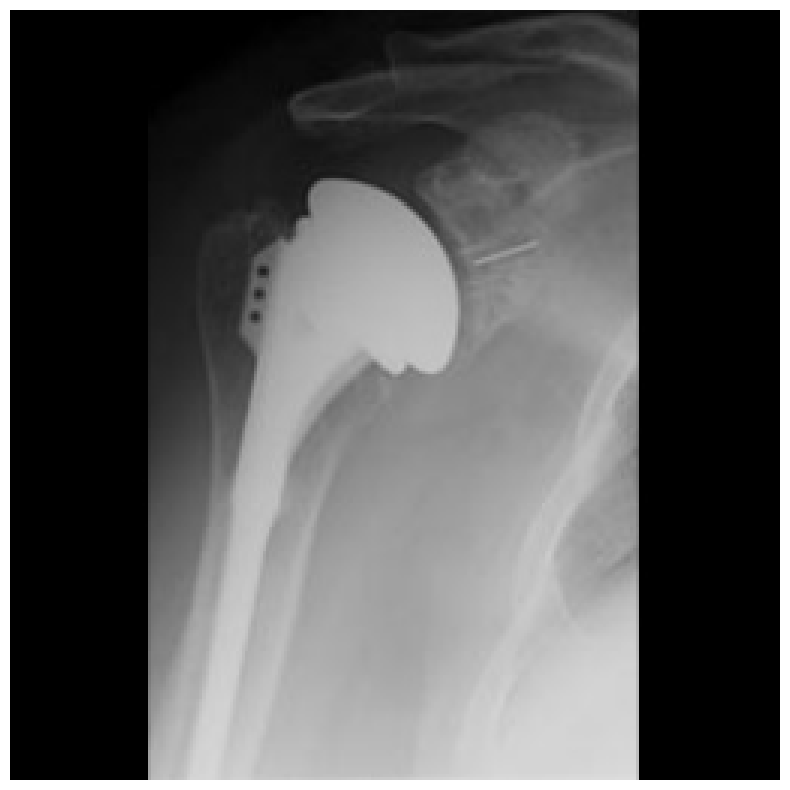

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0])
plt.axis('off')

In [5]:
import tensorflow_addons as tfa
from vit_keras import vit

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split


# Split the data
x_train, x_test, y_train, y_test = train_test_split(images, labels.astype(int), test_size=0.2, random_state=42, stratify=labels.astype(int))



In [7]:
def mlp_layer(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = keras.layers.Dense(units, activation = tf.nn.gelu)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    return x

class Patches(keras.layers.Layer): # split image to small blocks
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [8]:
test_img = images[0]
new_img = tf.expand_dims(test_img, axis=0)
print(np.min(new_img), np.max(new_img))


0.0 0.8665288


In [9]:
def create_patch(patch_size, img):
  patches = Patches(patch_size)(img)
  print(f'Image size: {256} X {256}')
  print(f'Patch size: {patch_size} X {patch_size}')
  print(f'Patches per image: {patches.shape[1]}')
  print(f'Elements per patch: {patches.shape[-1]}')
  return patches
patches_att = create_patch(10, new_img)

Image size: 256 X 256
Patch size: 10 X 10
Patches per image: 625
Elements per patch: 300


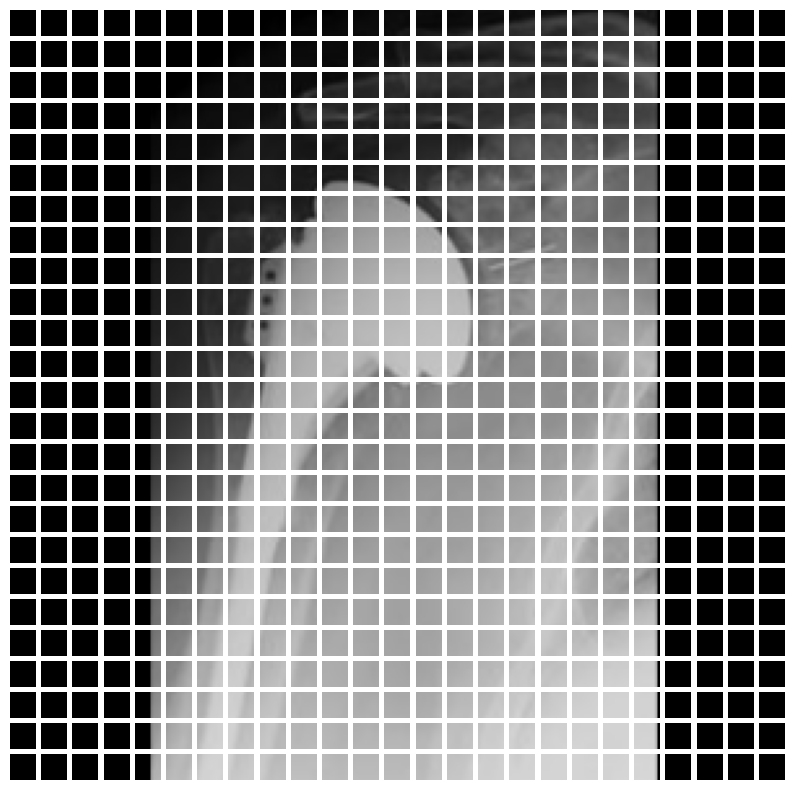

In [10]:
def plot_attention(patches, patch_size):
  n = int(np.sqrt(patches.shape[1]))
  plt.figure(figsize=(10, 10))

  for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('float32'))
    plt.axis('off')

plot_attention(patches_att, 10)

In [11]:
test_img = images[32]
new_img = tf.expand_dims(test_img, axis=0)
print(np.min(new_img), np.max(new_img))

patches_att = create_patch(20, new_img)

0.0 0.8608339
Image size: 256 X 256
Patch size: 20 X 20
Patches per image: 144
Elements per patch: 1200


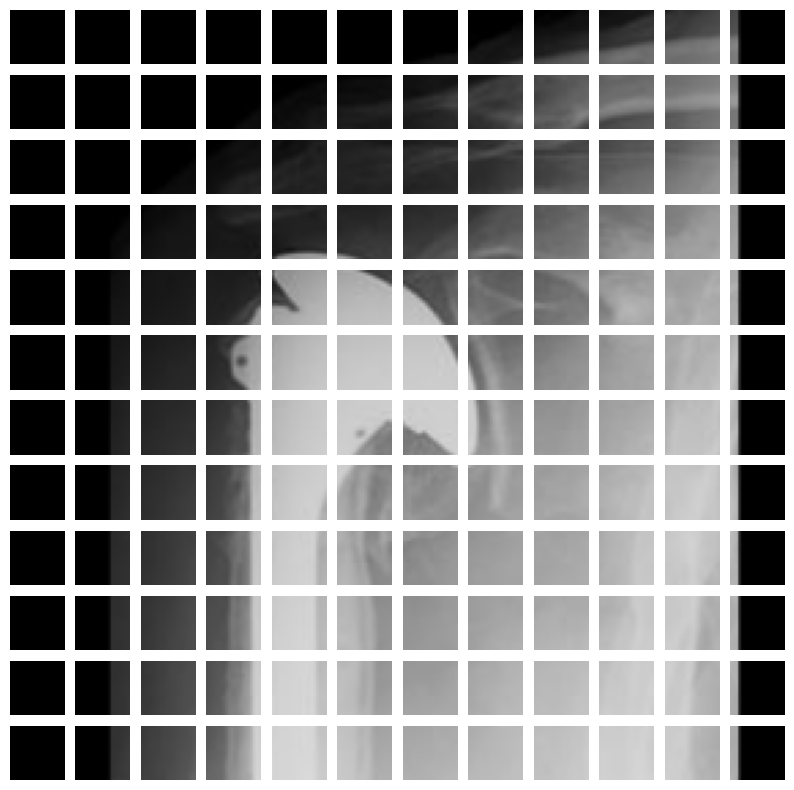

In [12]:
plot_attention(patches_att, 20)

In [13]:

# Vision Transformer hyper parameters

learning_rate = 3e-5
weight_decay = 0.0001
num_epochs = 25 # default

patch_size = 20  # Size of the patches to be extract from the input images
num_patches = (256 // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [14]:
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units = projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def vision_transformer():
    inputs = keras.layers.Input(shape = (256, 256, 3))

    # Create patches.
    patches = Patches(patch_size)(inputs)

    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):

        # Layer normalization 1.
        x = keras.layers.LayerNormalization(epsilon = 1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads = num_heads, key_dim = projection_dim, dropout = 0.1
        )(x, x)

        # Skip connection 1.
        y = keras.layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        z = keras.layers.LayerNormalization(epsilon = 1e-5)(y)

        # MLP.
        z = mlp_layer(z, hidden_units = transformer_units, dropout_rate = 0.1)

        # Skip connection 2.
        encoded_patches = keras.layers.Add()([z, y])

    # Create tensor.
    representation = keras.layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.5)(representation)

    # Add MLP layer
    features = mlp_layer(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)

    # Classify outputs.
    logits = keras.layers.Dense(4)(features)

    # Create the model.
    model = tf.keras.Model(inputs = inputs, outputs = logits)

    return model

In [15]:
vit_model = vit.vit_b32(
        image_size = 256,
        activation = 'softmax',
        pretrained = True,
        include_top = True,
        pretrained_top = False,
        classes = 4,
        weights="imagenet21k+imagenet2012")

vit_model.summary()

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 8, 8
  warnings.warn(


Model: "vit-b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 8, 8, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 64, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 65, 768)           768       
                                                                 
 Transformer/posembed_input  (None, 65, 768)           49920     
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 65, 768),         7087872   
  (TransformerBlock)          (None, 12, None, None)       

In [16]:
decay_steps = 10
initial_learning_rate = learning_rate
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, decay_steps)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

optimizer = tfa.optimizers.AdamW(learning_rate = learning_rate, weight_decay=weight_decay)


vit_model.compile(optimizer = optimizer,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = [keras.metrics.SparseCategoricalAccuracy(name="accuracy")])



callbacks = [lr_scheduler]

# labels = keras.utils.to_categorical(labels, 4)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 1e-4, patience = 8, mode = 'max', restore_best_weights = True, verbose = 1)
vit_model.fit(x_train, y_train, epochs = 50, batch_size = 8, validation_split=0.1,callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


148/148 [==============================] - 1004s 7s/step - loss: 1.2337 - accuracy: 0.4122 - val_loss: 1.1290 - val_accuracy: 0.4773
Epoch 2/50
148/148 [==============================] - 957s 6s/step - loss: 1.0961 - accuracy: 0.4538 - val_loss: 1.1071 - val_accuracy: 0.4470
Epoch 3/50
148/148 [==============================] - 949s 6s/step - loss: 0.9777 - accuracy: 0.5335 - val_loss: 1.1606 - val_accuracy: 0.4924
Epoch 4/50
148/148 [==============================] - 959s 6s/step - loss: 0.8496 - accuracy: 0.6031 - val_loss: 1.5658 - val_accuracy: 0.4015
Epoch 5/50
148/148 [==============================] - 947s 6s/step - loss: 0.8237 - accuracy: 0.5946 - val_loss: 1.2865 - val_accuracy: 0.4848
Epoch 6/50
148/148 [==============================] - 955s 6s/step - loss: 0.7424 - accuracy: 0.6234 - val_loss: 1.2569 - val_accuracy: 0.5227
Epoch 7/50
148/148 [==============================] - 970s 7s/step - loss: 0.6958 - accuracy: 0.6641 - val_loss: 1.3748 - val_accuracy: 0.5303
Epoch 8/5

In [20]:
# Evaluate the model
vit_model.evaluate(x_test, y_test)


11/11 [==============================] - 73s 7s/step - loss: 1.1906 - accuracy: 0.5213


[1.1905858516693115, 0.5213414430618286]

In [24]:
# Predict classes for test images
test_pred = vit_model.predict(x_test)
test_pred_classes = np.argmax(test_pred, axis=1)

11/11 [==============================] - 93s 8s/step


In [25]:
from sklearn.metrics import classification_report

# Generate confusion matrix
conf_mat = confusion_matrix(y_test, test_pred_classes)

# Define the class names
classes = ['Cofield','Depuy','Tornier','Zimmer']

# Print classification report
print("Classification Report:")
print(classification_report(y_test, test_pred_classes, target_names=classes))


Classification Report:
              precision    recall  f1-score   support

     Cofield       0.57      0.40      0.47        82
       Depuy       0.68      0.86      0.76        59
     Tornier       0.45      0.69      0.55        98
      Zimmer       0.42      0.21      0.28        89

    accuracy                           0.52       328
   macro avg       0.53      0.54      0.52       328
weighted avg       0.51      0.52      0.50       328



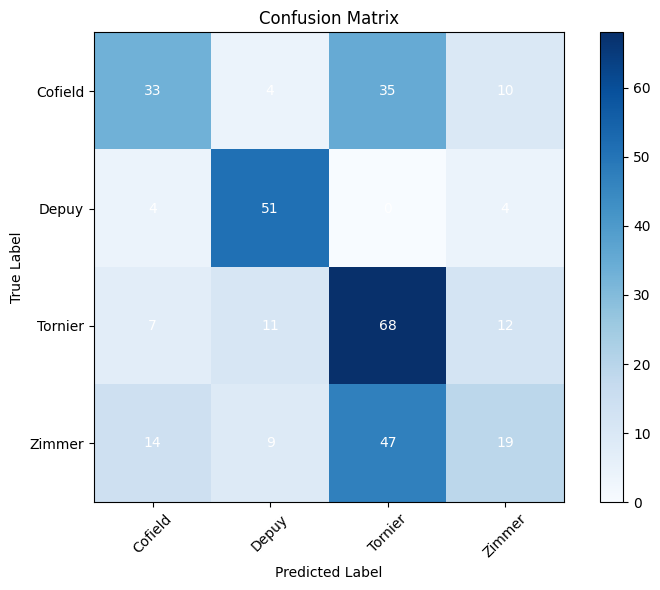

In [26]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, cmap=plt.cm.Blues, interpolation ='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_mat[i, j]), ha='center', va='center', color='white')
plt.tight_layout()
plt.show()